<a href="https://colab.research.google.com/github/Saadman53/Thesis-Human-Activity-Recognition/blob/main/Alexnet_Classification(Prewitt).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')
gdrive_path = "drive/My Drive/Dataset/alexnet_extracted_prewitt_4096.mat"
sensor_path = "drive/My Drive/Dataset/sensor_features_acc_gyro.mat"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data

import torchvision
import torchvision.transforms as transforms



import random
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


from torch.utils.data import DataLoader, ConcatDataset
# from torchvision import transforms
from sklearn.model_selection  import StratifiedKFold

import torch.optim.lr_scheduler as lr_scheduler
%matplotlib inline

import scipy.io as sio
torch.autograd.set_detect_anomaly(True)


from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn


In [15]:
dat = sio.loadmat(gdrive_path)

In [16]:
files = dat['filename'].ravel()
files = [x.replace(" ","") for x in files ]
map_filename_data = dict(zip(files, dat['data'].reshape(1165,4096)))
map_filename_label = dict(zip(files, dat['labels'].ravel()))
sensor_Dat = sio.loadmat(sensor_path)
train_files = sensor_Dat['train_filename'].ravel()
test_files = sensor_Dat['test_filename'].ravel()
train_X = []
train_y = []
test_X = []
test_y = []
for file in train_files:
  train_X.append(map_filename_data[file[0]])
  train_y.append(map_filename_label[file[0]])

for file in test_files:
  test_X.append(map_filename_data[file[0]])
  test_y.append(map_filename_label[file[0]])

X_train = np.array(train_X)
X_test = np.array(test_X)
y_train = np.array(train_y)
y_test = np.array(test_y)

In [17]:
alexnet_features = {'X_train':X_train, 'X_test': X_test, 'y_train': y_train, 'y_test':y_test}
sio.savemat("drive/My Drive/Dataset/alexnet_prewitt_features.mat",alexnet_features)

In [18]:
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42, stratify = y)

In [19]:
class DNN(nn.Module):
    def __init__(self,input_size,output_size):
        super(DNN,self).__init__()
        self.hidden1 = nn.Linear(input_size,2048)
        self.hidden2 = nn.Linear(2048,1024)
        self.hidden3 = nn.Linear(1024,256)
        self.hidden4 = nn.Linear(256,64)
        self.output = nn.Linear(64,output_size)
        self.softmax = F.softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(2048)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.batchnorm4 = nn.BatchNorm1d(64)
    
    def forward(self,x):
        out = self.hidden1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        
        out = self.hidden2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden4(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.output(out)
        return out

In [20]:
def extract_batch(X,y,batch_size,step,no_of_samples):
  l = (step-1)*batch_size
  return X[l:(l+batch_size)],y[l:min(no_of_samples,l+batch_size)]


In [21]:
def model_training_evaluation(X_train, X_test, y_train, y_test):
  train_X = X_train
  test_X = X_test
  scaler = MinMaxScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_X = torch.from_numpy(train_X.astype(np.float32))
  test_X = torch.from_numpy(test_X.astype(np.float32))
  train_y =  torch.tensor(y_train.astype(np.float32))
  test_y =  torch.tensor(y_test.astype(np.float32))
  input_size = train_X.shape[1]
  output_size = torch.unique(train_y).shape[0]
  learning_rate = 0.001
  num_epochs = 1001
  n_samples = train_X.shape[0]
  criterion = nn.CrossEntropyLoss(reduction='sum')
  best_lr = None
  best_loss = 100000
  best_model = None
  best_train_loss = None
  best_val_loss = None
  best_epoch = None
  skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
  for lr in [0.01]:
    #print(f"Learning rate: {lr}:")
    net = DNN(input_size, output_size)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)  
    cnt = 1
    figure, ax = plt.subplots(3,figsize=(10,10))
    figure.tight_layout(pad=5.0)
    for train_index, val_index in skf.split(X_train, y_train):
      train_X_fold = train_X[train_index]
      train_y_fold = train_y[train_index]
      val_x_fold = train_X[val_index]
      val_y_fold = train_y[val_index]
      n_samples = train_X_fold.shape[0]
      batch_size = int(n_samples/5)
      train_loss = []
      val_loss = []
      print(f"Training for fold {cnt}")
      for epoch in range(num_epochs):
        step = 1
        while(batch_size*step<=n_samples):
          x,y =  extract_batch(train_X_fold,train_y_fold, batch_size, step, n_samples)
          # Forward Propagation
          y_predicted = net(x)
          loss = criterion(y_predicted,  torch.tensor(y, dtype=torch.long))
          # Backward propagation and update
          loss.backward()
          optimizer.step()
          # Performing zero grad before new step
          optimizer.zero_grad()
          step = step+1
        t_loss = criterion( net(train_X_fold),  torch.tensor(train_y_fold, dtype=torch.long)).item()/train_X_fold.shape[0]
        v_loss = criterion( net(val_x_fold),  torch.tensor(val_y_fold, dtype=torch.long)).item()/val_x_fold.shape[0]
        train_loss.append(t_loss) 
        val_loss.append(v_loss)
        if(v_loss<best_loss):
          best_lr = lr
          best_loss = v_loss
          best_model = net
          best_epoch = epoch
        print(epoch*100/num_epochs)
      m = "Fold "+str(cnt)
      ax[cnt-1].title.set_text(m)
      ax[cnt-1].set_ylabel("Total Loss")
      ax[cnt-1].set_xlabel("No of Epochs")
      ax[cnt-1].plot(range(1001),train_loss, label = "train loss")
      ax[cnt-1].plot(range(1001),val_loss, label = "validation loss")
      cnt+=1
  y_pred = best_model(test_X)
  return best_model, y_pred


Training for fold 1
0.0
0.0999000999000999
0.1998001998001998
0.2997002997002997
0.3996003996003996
0.4995004995004995
0.5994005994005994
0.6993006993006993
0.7992007992007992
0.8991008991008991
0.999000999000999
1.098901098901099
1.1988011988011988
1.2987012987012987
1.3986013986013985
1.4985014985014986
1.5984015984015985
1.6983016983016983
1.7982017982017982
1.898101898101898
1.998001998001998
2.097902097902098
2.197802197802198
2.2977022977022976
2.3976023976023977
2.4975024975024973
2.5974025974025974
2.6973026973026974
2.797202797202797
2.897102897102897
2.997002997002997
3.096903096903097
3.196803196803197
3.2967032967032965
3.3966033966033966
3.4965034965034967
3.5964035964035963
3.6963036963036964
3.796203796203796
3.896103896103896
3.996003996003996
4.095904095904096
4.195804195804196
4.2957042957042955
4.395604395604396
4.495504495504496
4.595404595404595
4.695304695304696
4.795204795204795
4.895104895104895
4.995004995004995
5.094905094905095
5.194805194805195
5.29470529470

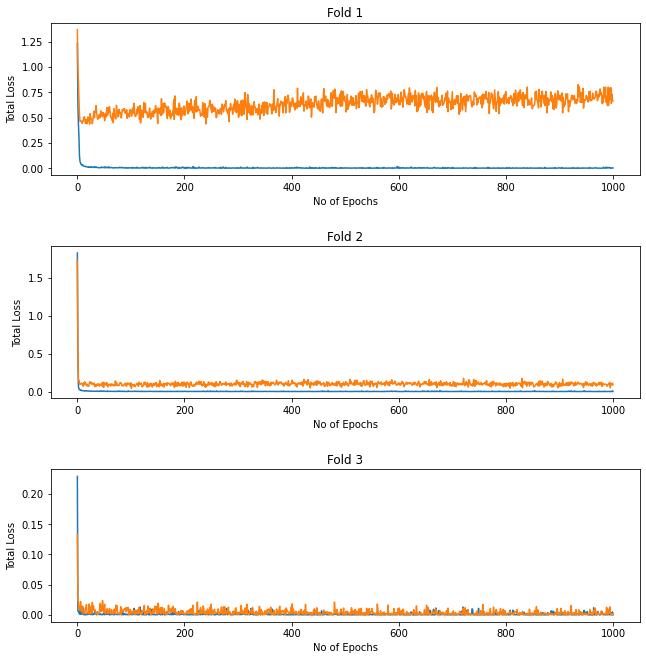

In [22]:
model, pred = model_training_evaluation(X_train, X_test, y_train, y_test)

In [29]:
def cf_matrix(y_pred, test_y):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred = torch.max(y_pred_softmax, dim = 1)
  y_pred = y_pred.detach().numpy().ravel()
  correct_pred = (y_pred == test_y).astype(np.float)
  acc = correct_pred.sum()*100.0 / y_pred.shape[0]
  cm = confusion_matrix(test_y.ravel(), y_pred)
  recall = np.mean(recall_score(test_y.ravel(), y_pred, average=None))*100.0
  precision = np.mean(precision_score(test_y.ravel(), y_pred, average=None))*100.0
  f,ax=plt.subplots(figsize=(20,10))
  sns.heatmap(cm,annot=True,fmt='.0f', cmap="Blues")
  print(f"Accuracy: {acc:.2f}%")
  print(f"Precision: {precision:.2f}%")
  print(f"Recall: {recall:.2f}%")
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
  return cm,acc, recall, precision

Accuracy: 96.00%
Precision: 96.25%
Recall: 96.00%


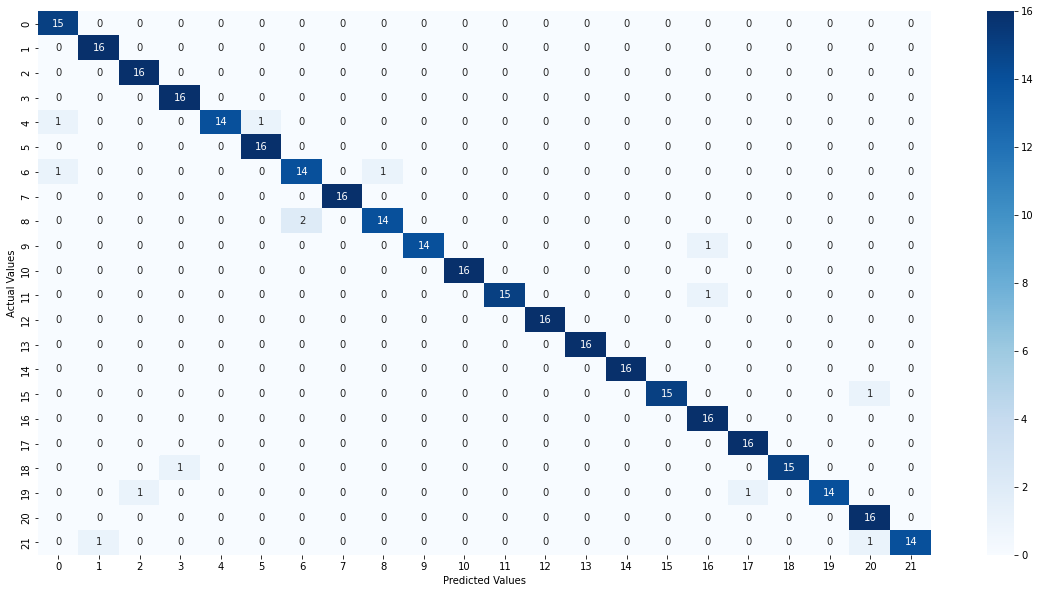

In [32]:
cm,acc, recall, precision = cf_matrix(pred, y_test)

In [33]:
pred_dict = {"preds":pred.detach().numpy(), 'y_test':y_test}
sio.savemat("drive/My Drive/Dataset/alexnet_prewitt_predictions.mat", pred_dict)

In [34]:
model_save_name = 'Prewitt_DNN.pt'
path = F"/content/drive/My Drive/Dataset/Models/{model_save_name}" 
torch.save(model.state_dict(), path)